In [3]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.initializers import RandomNormal
from keras import Sequential
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import GroupNormalization
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Conv2DTranspose
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import Input
from keras import Model
from numpy import savez_compressed
from numpy import load
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from glob import glob
from datetime import datetime
from IPython import display

import numpy as np
import tensorflow as tf
import os
import pathlib
#import splitfolders
import matplotlib.pyplot as plt
import cv2
import time

ModuleNotFoundError: No module named 'keras'

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
!pip install split-folders

In [9]:
!pip install opencv-python

In [ ]:
!ls

In [ ]:
splitfolders.ratio('/hdd/Datasets/sar2opt_raw_data/tiles', output="/hdd/Datasets/sar2opt_raw_data/split_data", seed=1337, ratio=(.8, .2))

## Step 1: Dataset Loading and Preprocessing 

In [10]:
PATH = pathlib.Path('/hdd/Datasets/sar2opt_raw_data/')

def load_img(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  sar_image = image[:, w:, :]
  opt_image = image[:, :w, :]

  # Convert both images to float32 tensors
  sar_image = tf.cast(sar_image, tf.float32)
  opt_image = tf.cast(opt_image, tf.float32)
    
  return sar_image, opt_image

2023-09-27 15:28:13.077866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 15:28:13.078430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 15:28:13.078879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

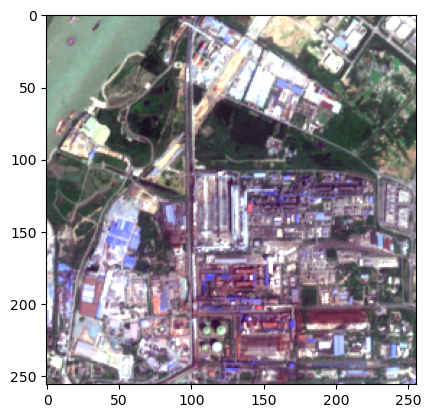

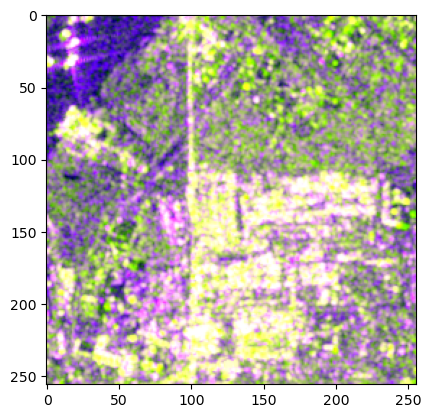

In [11]:
sar, opt = load_img(os.path.join(PATH, 'train/1.png'))
plt.figure()
plt.imshow(opt / 255.0)
plt.figure()
plt.imshow(sar / 255.0, cmap="gray")

In [12]:
s2paths = glob('/hdd/Datasets/sar2opt_raw_data/split_data/test/s2_rgb_tiles/*.png')
s1paths = glob('/hdd/Datasets/sar2opt_raw_data/split_data/test/s1_rgb_tiles/*.png')
test_opts = []
test_sars = []
for idx in np.arange(len(s2paths)):
    test_opts.append(s2paths[idx])
    test_sars.append(s1paths[idx])

In [13]:
train_sars = np.sort(train_sars)
train_opts = np.sort(train_opts)

NameError: name 'train_sars' is not defined

In [ ]:
for idx in np.arange(len(test_sars)):
    sar = cv2.imread(test_sars[idx])
    opt = cv2.imread(test_opts[idx])
    im_h = cv2.hconcat([opt, sar])
    cv2.imwrite(f'/hdd/Datasets/sar2opt_raw_data/test/{idx+1}.png', im_h)

In [12]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [13]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image


In [14]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]


In [15]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image


In [16]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image


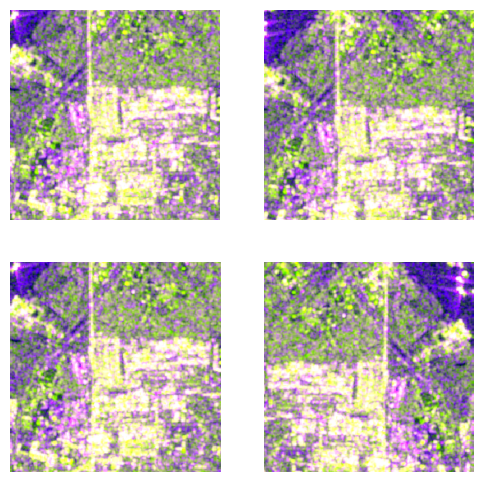

In [17]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_sar, rj_opt = random_jitter(sar, opt)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_sar / 255.0)
  plt.axis('off')
plt.show()


In [20]:
def load_image_train(image_file):
  input_image, real_image = load_img(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image


In [18]:
def load_image_test(image_file):
  input_image, real_image = load_img(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image


In [22]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.png'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [19]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.png'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.png'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [24]:
sample_sar = next(iter(train_dataset))

In [25]:
sample_sar

(<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
 array([[[[ 0.7490196 ,  0.30980396,  0.7411765 ],
          [ 0.5137255 , -0.06666666,  0.85882354],
          [ 0.02745104, -0.27058822,  0.3803922 ],
          ...,
          [-0.16862744, -0.10588235, -0.12156862],
          [-0.12941176,  0.06666672, -0.27058822],
          [ 0.10588241, -0.1607843 ,  0.37254906]],
 
         [[ 0.8352941 ,  0.52156866,  0.60784316],
          [ 0.6156863 ,  0.2941177 ,  0.5686275 ],
          [ 0.00392163,  0.02745104, -0.02745098],
          ...,
          [-0.35686272, -0.03529412, -0.47450978],
          [-0.16862744,  0.20000005, -0.4980392 ],
          [ 0.09019613,  0.10588241,  0.01176476]],
 
         [[ 0.69411767,  0.6627451 ,  0.2313726 ],
          [ 0.47450984,  0.5294118 ,  0.05882359],
          [ 0.1686275 ,  0.22352946, -0.02745098],
          ...,
          [-0.27058822,  0.07450986, -0.4980392 ],
          [-0.12941176,  0.27843142, -0.5294118 ],
          [ 0.15294123,

---
## Step 2: Making the Discriminator (D) model

The Discriminator is a deep ConvNet that performs image classification. It takes a source image as input and predicts the likelihood of whether the target image is a real or fake image. Two discriminator models are used, one for Domain-A (horses) and one for Domain-B (zebras).

The design is based on the effective receptive field of the model, which defines the relationship between one output of the model to the number of pixels in the input image. 

This is called a **PatchGAN** model and is carefully designed so that each output prediction of the model maps to a 70x70 square or patch of the input image. The benefit of this approach is that the same model can be applied to the input images of different sizes, e.g. larger or smaller than 256x256 pixels.

In [20]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


In [21]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(sar, 0))
print (down_result.shape)

2023-09-27 15:28:34.203834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900


(1, 128, 128, 3)


In [22]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [23]:
discriminator = Discriminator()
plot_model(discriminator, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
# test the discriminator
disc_out = discriminator([sar[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

NameError: name 'gen_output' is not defined

---
## Step 3: Making the Generator (G) Model
The generator is an encoder-decoder model architecture. 

The model takes a source image (e.g. horse photo) and generates a target image (e.g. zebra photo). 

It does this by first downsampling or encoding the input image down to a bottelneck layer, then interpreting the encoding with a number of ResNet layers that use skip connections, followed by a series of layers that upsample or decode the representation to the size of the output image.

In [25]:
OUTPUT_CHANNELS = 3

In [26]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [27]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)


(1, 256, 256, 3)


In [28]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [29]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


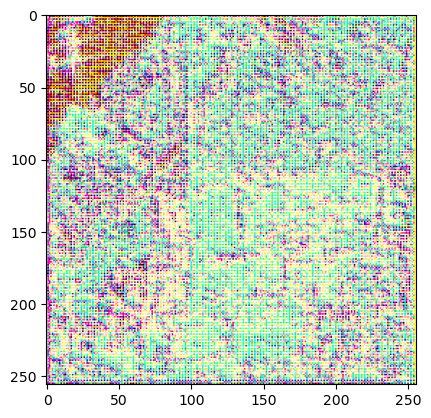

In [30]:
# test the generator
gen_output = generator(sar[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [31]:
LAMBDA = 100

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [32]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_obj(tf.ones_like(disc_generated_output), disc_generated_output) # gen loss

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)# + mse(target, gen_output)

  return total_gen_loss, gan_loss, l1_loss

---
## Step 4: Define the optimizers and a chackpoint-saver

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [40]:
checkpoint_dir = 'sar2opt/pix2pix/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

---
## Step 5: Generate Images
Write a function to plot some images during training
* Pass images from test set to the generator
* The generator will then translate the input image into the output
* The last step is to plot the predictions

In [35]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


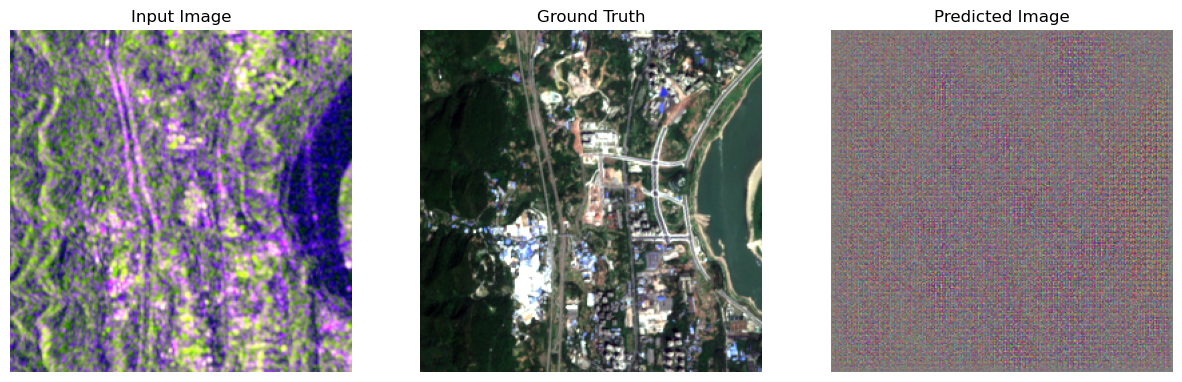

In [36]:
# Test the generate images function
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

---
## Step 6: Training
* For each example input generate an output
* The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
* Next, calculate the generator and discriminator loss.
* Then, calculate the gradients of loss w.r.t. both the generator and the discriminator variables (inputs) and apply those to the optimizer.
* Finally, log the losses to TensorBoard

In [ ]:
log_dir="sar2opt/v_2/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))


In [ ]:
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)


In [ ]:
# Actual training loop
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir={log_dir} --host=0.0.0.0

In [ ]:
fit(train_dataset, test_dataset, steps=40000)

In [41]:
ls {checkpoint_dir}

checkpoint                  ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index                ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index                ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index                ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


In [42]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

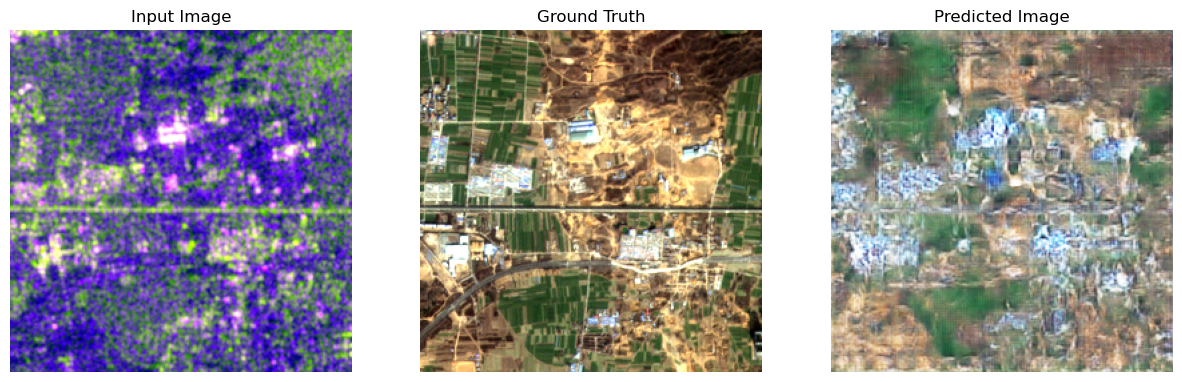

In [68]:
# Run the trained model on a few examples from the test set
for sar, opt in test_dataset.take(1):
  generate_images(generator, sar, opt)

In [1]:
for sar, opt in test_dataset:
    print(opt)

NameError: name 'test_dataset' is not defined

In [2]:
test_dataset

NameError: name 'test_dataset' is not defined